# Text Analytics Coursework

In [1]:
# Use HuggingFace's datasets library to access the Emotion dataset
from datasets import load_dataset
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# %load_ext autoreload
# %autoreload 2

# Part 1: Tweet Emotion Classification
# 1. Load the dataset
Use the TweetEval dataset from HuggingFace's datasets library to load the Emotion dataset. The dataset has three splits: train, validation, and test. Load the train, validation, and test splits into separate variables.
The labels in the dataset are: [0,1,2,3] which correspond to the emotions: [anger, joy, optimism, sadness].

In [2]:
cache_dir = "./NLP_data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")


val_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="validation",
    cache_dir=cache_dir,
)
print(f"Development/validation dataset with {len(val_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="test",
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset)} instances loaded")

# Access the input text and target labels like this...
train_texts = train_dataset['text']
train_labels = train_dataset['label']

val_texts = val_dataset['text']
val_labels = val_dataset['label']

test_texts = test_dataset['text']
test_labels = test_dataset['label']

Training dataset with 3257 instances loaded
Development/validation dataset with 374 instances loaded
Test dataset with 1421 instances loaded


# 2. Non-Neural Classifier
## 2.1. Preprocessing
### 2.1.1. Text Cleaning

The text cleaning step includes removing URLs, @mentions and #hashtags, converting to lowercase, removing punctuation. Lexical annotation and word form reduction by the result of lexical annotation. These steps help to reduce the noise and diversity of text data and improve the performance of text analysis.

In [3]:
from nltk.corpus import wordnet
import nltk
from nltk import WordNetLemmatizer

# 确保已下载nltk的wordnet和stopwords数据包
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

# 映射nltk的词性标签到wordnet的词性标签。用于词形还原
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # 移除URLs
    text = re.sub(r'\@\w+|\#','', text) # 移除@mentions和hashtags
    text = text.lower() # 转换为小写
    text = text.translate(str.maketrans("", "", "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~")) # 移除标点符号
    
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))   # 词性标注
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged) # 将nltk标记转换为wordnet标记
    
    lemmatized_sentence = []
    for word, tag in wordnet_tagged: # 词形还原
        if tag is None: # 
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

# 应用词形还原到你的文本数据
train_texts_lemmatized = [lemmatize_text(text) for text in train_texts]
val_texts_lemmatized = [lemmatize_text(text) for text in val_texts]
test_texts_lemmatized = [lemmatize_text(text) for text in test_texts]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yhb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yhb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yhb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train_texts_lemmatized[0:3]

['“ worry be a down payment on a problem you may never have joyce meyer motivation leadership worry',
 'my roommate its okay that we cant spell because we have autocorrect terrible firstworldprobs',
 'no but thats so cute atsu be probably shy about photo before but cherry help her out uwu']

### 2.1.2. Vectorization
Use the TF-IDF vectorizer to convert the text data into numerical form.

In [5]:
# TF-IDF向量化
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# 将训练和验证数据集合并进行向量化，这样可以提高模型的泛化能力
X_all_lemmatized = train_texts_lemmatized + val_texts_lemmatized
y_all = train_labels + val_labels

# 向量化处理
X_all_tfidf = tfidf_vectorizer.fit_transform(X_all_lemmatized)
X_test_tfidf = tfidf_vectorizer.transform(test_texts_lemmatized)

# 分割数据集，这里重新分割是因为我们合并了训练集和验证集进行统一的向量化
x_train_tfidf, x_val_tfidf, y_train, y_val = train_test_split(
    X_all_tfidf, y_all, test_size=0.2, random_state=42)

## 2.2. Classification Model

In [6]:
# grid search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10,100],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5, n_jobs=-1,verbose=True)
grid_search.fit(x_train_tfidf, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
print("Best estimator: ", grid_search.best_estimator_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score:  0.6632245237106059
Best estimator:  SVC(C=10, class_weight='balanced', gamma=0.1)


In [7]:
# 训练SVM模型
# C是正则化参数，C越大，正则化越弱，则模型越容易过拟合；gamma是rbf核函数的系数，gamma越大，模型越容易过拟合
svm_model = SVC(random_state=42, kernel='rbf', C=10, gamma=0.1,class_weight='balanced')
svm_model.fit(x_train_tfidf, y_train)

# 预测验证集
y_train_pred = svm_model.predict(x_train_tfidf)
y_val_pred = svm_model.predict(x_val_tfidf)
y_test_pred = svm_model.predict(X_test_tfidf)

print("Train Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# 性能评估
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# 测试集性能评估
print("Test Accuracy: ", accuracy_score(test_labels, y_test_pred))
print("Test Classification Report:\n", classification_report(test_labels, y_test_pred))

Train Accuracy:  0.9800275482093664
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      1257
           1       0.97      0.99      0.98       648
           2       0.96      1.00      0.98       249
           3       0.97      0.99      0.98       750

    accuracy                           0.98      2904
   macro avg       0.97      0.99      0.98      2904
weighted avg       0.98      0.98      0.98      2904

Validation Accuracy:  0.6643741403026134
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.82      0.75       303
           1       0.62      0.57      0.60       157
           2       0.57      0.29      0.38        73
           3       0.66      0.63      0.65       194

    accuracy                           0.66       727
   macro avg       0.64      0.58      0.59       727
weighted avg       0.66      0.66      0.65       727

Test 

In [8]:
# cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model, X_all_tfidf, y_all, cv=5, scoring='f1_macro',n_jobs=-1)
print("Cross-validation scores: ", scores)
print("Mean CV F1-score: ", scores.mean())

Cross-validation scores:  [0.61300786 0.57654689 0.62631308 0.63683725 0.54114124]
Mean CV F1-score:  0.5987692625767528


## 2.3 Improving the Model
Add Lexicon Features, using NLTK's VADER sentiment analysis tool to extract sentiment scores from the text data. Add these sentiment scores as additional features to the TF-IDF vectorized features.

In [9]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# 实例化情感分析器
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yhb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
from scipy.sparse import hstack

# 初始化VADER情感分析器
sia = SentimentIntensityAnalyzer()

X_all_lemmatized = train_texts_lemmatized + val_texts_lemmatized
y_all = train_labels + val_labels

# 计算情感分数 # compound是综合得分
x_all_sentiments = [sia.polarity_scores(text)['compound'] for text in X_all_lemmatized]
x_test_sentiments = [sia.polarity_scores(text)['compound'] for text in test_texts_lemmatized]

x_all_sentiments = np.array(x_all_sentiments).reshape(-1, 1)
x_test_sentiments = np.array(x_test_sentiments).reshape(-1, 1)

# 合并情感分数和TF-IDF特征
# 向量化处理
X_all_tfidf = tfidf_vectorizer.fit_transform(X_all_lemmatized)
X_test_tfidf = tfidf_vectorizer.transform(test_texts_lemmatized)

X_all = hstack([X_all_tfidf, x_all_sentiments])
X_test = hstack([X_test_tfidf, x_test_sentiments])

# 分割数据集
x_train_augmented, x_val_augmented, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42)

In [11]:
# 训练SVM模型
svm_model = SVC(random_state=42, kernel='rbf', C=10, gamma=0.1,class_weight='balanced')
svm_model.fit(x_train_augmented, y_train)

# 预测验证集
y_train_pred = svm_model.predict(x_train_augmented)
y_val_pred = svm_model.predict(x_val_augmented)
y_test_pred = svm_model.predict(X_test)

print("Train Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# 性能评估
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# 测试集性能评估
print("Test Accuracy: ", accuracy_score(test_labels, y_test_pred))
print("Test Classification Report:\n", classification_report(test_labels, y_test_pred))

Train Accuracy:  0.9807162534435262
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      1257
           1       0.98      0.99      0.98       648
           2       0.96      1.00      0.98       249
           3       0.96      0.99      0.98       750

    accuracy                           0.98      2904
   macro avg       0.97      0.99      0.98      2904
weighted avg       0.98      0.98      0.98      2904

Validation Accuracy:  0.6753782668500687
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.81      0.76       303
           1       0.60      0.66      0.63       157
           2       0.63      0.30      0.41        73
           3       0.68      0.62      0.65       194

    accuracy                           0.68       727
   macro avg       0.66      0.60      0.61       727
weighted avg       0.67      0.68      0.67       727

Test 

### Insights
比较添加情感分数特征前后的性能，发现分类器的性能有所提升。这表明情感分数特征对于情感分类任务是有用的。
具体表现为：对于类别1（joy），recall显著提高，对于类别2（optimise），precision显著提高。这表明模型能够更好地识别这两个类别。这可能是因为情感得分提供了一种直接量化文本情感倾向的方式，帮助模型捕捉到了一些仅通过文本内容难以明确表达的情感特征。这一结果表明，对于文本分类任务，结合内容分析和情感倾向的量化分析，可以有效提升模型的预测准确性和泛化能力。

Comparing the performance before and after adding the sentiment score feature, it is found that the performance of the classifier has improved. This indicates that the sentiment score feature is useful for the sentiment classification task.

This is shown by the significant improvement in Recall for category 1 (Joy) and Precision for category 2 (Optimise). This indicates that the model is better able to recognize these two categories. This may be due to the fact that the sentiment score provides a way to directly quantify the sentiment tendency of the text, helping the model to capture some of the sentiment features that are difficult to express explicitly through the text content alone. This result suggests that for text categorization tasks, combining content analysis and quantitative analysis of sentiment tendencies can effectively improve the prediction accuracy and generalization ability of the model.


# 3. Deep Learning Classifier
## 3.1. Preprocessing
### 3.1.1. Length of Texts
We found that the maximum length of the text data is 36. As the hist plot can show the distribution of the length of the text data, we can see that most of the text data is less than 25 words. Therefore, we can set the maximum length of the text data to 25.

36

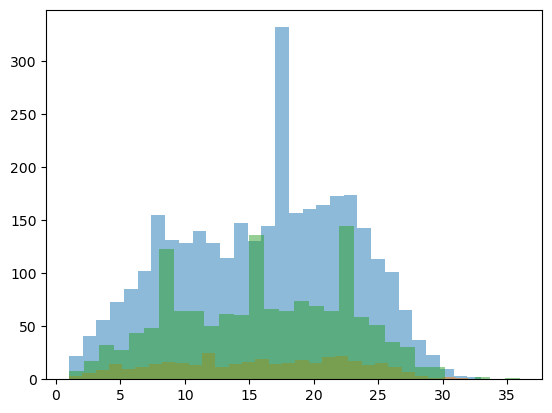

In [12]:
# 查看样本长度的分布
import matplotlib.pyplot as plt

train_texts_len = [len(text.split()) for text in train_texts]
val_texts_len = [len(text.split()) for text in val_texts]
test_texts_len = [len(text.split()) for text in test_texts]

plt.hist(train_texts_len, bins=30, alpha=0.5, label='train')
plt.hist(val_texts_len, bins=30, alpha=0.5, label='val')
plt.hist(test_texts_len, bins=30, alpha=0.5, label='test')

# 找出最长长度
max_len = max(max(train_texts_len), max(val_texts_len), max(test_texts_len))
max_len

### 3.1.2. Tokenization, Encoding, Padding&Truncating and Tensorization
Use BERT tokenizer to tokenize the text data. Then convert the tokenized text data into vocabulary index. Finally, pad and tensorize the text data and generate the DataLoader.

In [13]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer

# 初始化分词器，这里以 BERT 分词器为例
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # bert-base-uncased是一个预训练的模型,没有区分大小写（uncased），即所有的文本都被转换为小写，并且在创建词汇表时忽略了字母的大小写。

# 分词
def tokenize_data(texts):
    return [tokenizer.tokenize(text) for text in texts]

# 将分词转换为词汇表索引
def numericalize_tokens(tokenized_texts):
    return [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]

# 对每个序列进行截断和填充，max_length=25
def pad_and_tensorize(batch, max_length=25):
    # 对每个序列进行截断操作
    truncated_batch = [seq[:max_length] for seq in batch]
    # 分词的索引，这里的batch已经是截断后的数据
    padded_batch = pad_sequence([torch.tensor(seq) for seq in truncated_batch], batch_first=True)
    return padded_batch

In [14]:
# DataLoader 需要一个 dataset 对象，这里我们构造一个简单的
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {'text': torch.tensor(self.encodings[idx], dtype=torch.long),
                'label': torch.tensor(self.labels[idx], dtype=torch.long)}

    def __len__(self):
        return len(self.labels)

# 创建数据集
train_dataset = TweetDataset(numericalize_tokens(tokenize_data(train_texts)), train_labels)
val_dataset = TweetDataset(numericalize_tokens(tokenize_data(val_texts)), val_labels)
test_dataset = TweetDataset(numericalize_tokens(tokenize_data(test_texts)), test_labels)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=pad_and_tensorize)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=pad_and_tensorize)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=pad_and_tensorize)

In [15]:
train_loader.dataset[13]

{'text': tensor([ 2054,  1037,  8239, 14163, 29519,  1012,  1030,  5310,  1001, 23883,
          1012]),
 'label': tensor(0)}

Another way to tokenize the text data is to use the `batch_encode_plus` method of the BERT tokenizer. This method can tokenize the text data, add special tokens, pad and truncate the text data, and return the input IDs and attention masks in a dictionary.

In [16]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts):
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,  # 添加特殊标记，例如[CLS]和[SEP]
        max_length=25,  # 设定最大序列长度
        padding='max_length',  # 进行填充以达到相同长度
        truncation=True,  # 截断超过最大长度的部分
        return_attention_mask=True,  # 返回attention_mask（区分填充和非填充部分）
        return_token_type_ids=False,  # 不返回token_type_ids(用于区分两个句子，如问答，本模型不需要)
        return_tensors='pt'  # 返回PyTorch张量
    )

# 对训练、验证和测试数据进行编码
encoded_train = encode_texts(train_texts)
encoded_val = encode_texts(val_texts)
encoded_test = encode_texts(test_texts)

In [17]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}  # 确保不修改原始数据
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

batch_size = 32

# 创建Dataset
train_dataset = TextDataset(encoded_train, train_labels)
val_dataset = TextDataset(encoded_val, val_labels)
test_dataset = TextDataset(encoded_test, test_labels)

# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [18]:
train_loader.dataset[13]

{'input_ids': tensor([  101,  2054,  1037,  8239, 14163, 29519,  1012,  1030,  5310,  1001,
         23883,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]),
 'labels': tensor(0)}

## 3.2. Training the Model
Download the pre-trained BERT model and fine-tune it on the emotion classification task.

In [23]:
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score
import numpy as np

def train(model, train_dataloader, val_dataloader, optimizer, scheduler, device, epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        
        # for batch in tqdm(train_dataloader, desc="Training"):
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()} 
            # 这行代码遍历从DataLoader迭代器返回的每个批次数据中的所有键值对。这里的batch是一个字典，它的键（k）是字符串，比如'input_ids'、'attention_mask'和'labels'，值（v）是对应的数据张量。{k: v.to(device) for k, v in batch.items()}这部分代码的作用是：
            # 对于字典中的每个键值对，将值（即张量）移动到指定的device（例如，GPU或CPU）。
         
            outputs = model(**batch)  # **batch将字典解包为关键字参数
            
            loss = outputs.loss
            total_train_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 梯度裁剪（防止梯度爆炸）
            
            optimizer.step()
            scheduler.step()
            model.zero_grad() 
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # 验证过程
        model.eval()
        total_val_loss = 0
        val_accuracy = []
        all_preds = []
        all_labels = []
        
        # for batch in tqdm(val_dataloader, desc="Validating"):
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}  
            
            with torch.no_grad():
                outputs = model(**batch) 
                
            loss = outputs.loss
            total_val_loss += loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).flatten()
            labels = batch['labels']  # 获取标签进行准确度计算
            # 将当前批次的预测和标签追加到列表中
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            val_accuracy.append(accuracy_score(labels.cpu().numpy(), preds.cpu().numpy()))
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss} | Val Loss: {avg_val_loss} | Val Accuracy: {np.mean(val_accuracy)}')
        print(classification_report(all_labels, all_preds))
    
    return train_losses, val_losses

In [24]:
def test(model, test_dataloader, device):
    model.eval()  # 设置模型为评估模式
    test_accuracy = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # 禁用梯度计算
        # for batch in tqdm(test_dataloader, desc="Testing"):
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}  # 将数据移至正确的设备
            labels = batch.pop('labels').cpu().numpy()  # 移除labels以单独处理，并转移到CPU
            
            outputs = model(**batch)  # 进行预测
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # 获取预测结果
            
            test_accuracy.append(accuracy_score(labels, preds))  # 计算准确率
            all_preds.extend(preds)  # 保存所有预测结果
            all_labels.extend(labels)  # 保存所有真实标签
    
    avg_accuracy = np.mean(test_accuracy)  # 计算平均准确率
    print(f"Test Accuracy: {avg_accuracy}")
    print(classification_report(all_labels, all_preds))

    return all_preds, all_labels, avg_accuracy

In [25]:
from torch.optim import AdamW
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup

# 加载预训练的BERT模型，指定分类数为4（你的情况下是0, 1, 2, 3四种情感）
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 50
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=total_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 开始训练、验证和绘制损失曲线
train_losses, val_losses = train(model, train_loader, val_loader, optimizer, scheduler, device, epochs)
# 使用测试集进行最终评估
test(model, test_loader, device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50 | Train Loss: 1.1574344781099581 | Val Loss: 0.8139502555131912 | Val Accuracy: 0.6818181818181818
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       160
           1       0.79      0.51      0.62        97
           2       0.67      0.21      0.32        28
           3       0.52      0.80      0.63        89

    accuracy                           0.68       374
   macro avg       0.69      0.58      0.59       374
weighted avg       0.71      0.68      0.67       374
Epoch 2/50 | Train Loss: 0.631608751766822 | Val Loss: 0.7447560479243597 | Val Accuracy: 0.7038352272727272
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       160
           1       0.61      0.78      0.68        97
           2       0.48      0.46      0.47        28
           3       0.76      0.53      0.62        89

    accuracy                           0.70       374
   macro avg       0.


KeyboardInterrupt



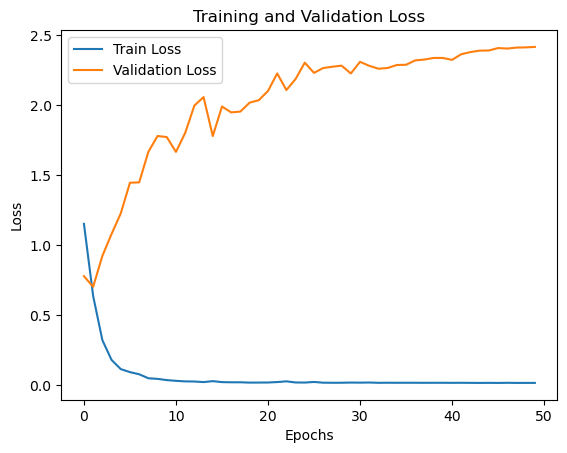

In [26]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()